<a href="https://colab.research.google.com/github/benardt/ML/blob/main/oring_optim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install optuna 1>/dev/null

Mounted at /content/drive


In [2]:
import shutil
import os
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import pandas as pd

import optuna
from optuna.trial import TrialState

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
!pip install import-ipynb
import import_ipynb
from importlib import reload # reload 

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=3bc36828709515e9f4861468582ff519ab1dc6b88b8c4feb8b363a69401479dc
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [4]:
!rm -r './mylib.ipynb'
!cp '/content/drive/My Drive/Colab Notebooks/mylib.ipynb' .
import mylib as ml
reload(ml)
ml.mytest('This is a test.')

rm: cannot remove './mylib.ipynb': No such file or directory
importing Jupyter notebook from mylib.ipynb
importing Jupyter notebook from mylib.ipynb
test import... This is a test.


In [5]:
FOLDER = 'oring11'

OUTPUT_SIZE = 63
BATCH_SIZE = 32
EPOCHS = 5

shutil.unpack_archive('/content/drive/My Drive/data/'+FOLDER+'.zip', '/tmp')

def get_data(isprint=False):

    trans_in = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                          transforms.ToTensor()])
    
    interpol = transforms.InterpolationMode.NEAREST
    trans_out = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                          transforms.Resize(OUTPUT_SIZE,interpolation=interpol),
                          transforms.ToTensor()])   

    class OringLandmarksDataset(Dataset):
        """Landmarks dataset."""

        def __init__(self, root_dir):
            """
            Args:
                root_dir (string): Directory with all the images.
            """

            self.root_dir = root_dir
            self.imgs = list(sorted(os.listdir(os.path.join(root_dir, "PNGImages"))))
            self.masks = list(sorted(os.listdir(os.path.join(root_dir, "Masks"))))

        def __len__(self):
            return len(self.imgs)

        def transform(self, x, y):

            image = trans_in(x)
            mask = trans_out(y)
            return image, mask

        def __getitem__(self, idx):
            if torch.is_tensor(idx):
                idx = idx.tolist()

            img_name = os.path.join(self.root_dir, "PNGImages", self.imgs[idx])
            im_invert = Image.open(img_name).convert('L')
            image = ImageOps.invert(im_invert)

            path = self.imgs[idx]

            mask_name = os.path.join(self.root_dir, "Masks", self.masks[idx])
            mask_invert = Image.open(mask_name).convert('L')
            mask = ImageOps.invert(mask_invert)

            x, y = self.transform(image, mask)
            return x, y

    trans_dataset = OringLandmarksDataset(root_dir='/tmp/'+FOLDER)

    train_len = int(0.6*len(trans_dataset))
    valid_len = len(trans_dataset)-train_len
    TrainData, ValidData = torch.utils.data.random_split(trans_dataset,[train_len, valid_len])

    mydataloader = { 'train':[],'valid':[]}
    mydataloader['train'] = DataLoader(TrainData, batch_size=BATCH_SIZE,
                            shuffle=True, pin_memory=True,num_workers=2)
    mydataloader['valid'] = DataLoader(ValidData, batch_size=BATCH_SIZE,
                            shuffle=True, pin_memory=True,num_workers=2)

    if isprint:
      for i_batch, (x,y) in enumerate(mydataloader['train']):
        print(i_batch, x[0].size(), y[0].size())
        x = transforms.functional.resize(x, OUTPUT_SIZE)
        ml.images_show(x[0],y[0],5)
        if i_batch == 2:
          break

    return mydataloader

dataloader = get_data(isprint=False)


In [15]:
def define_model(trial):

  layers = []
  out_features = [None,None]
  kernels_size = [None,None]

  i = 1 # first layer
  out_features[i] = trial.suggest_int("n_channels{}".format(i), 16, 80, 16)
  kernels_size[i] = trial.suggest_int("ker_sizes{}".format(i), 11, 19, 4)

  # 1st layer
  layers.append(nn.Conv2d(1,out_features[1],kernels_size[1],1,int((kernels_size[1]-1)/2)))
  layers.append(nn.MaxPool2d(15,2,7))

  # 2nd layer
  layers.append(nn.Conv2d(out_features[1],128,5,1,2))
  layers.append(nn.MaxPool2d(5,2,2))

  # 3rd layer
  layers.append(nn.Conv2d(128,128,3,1,1))
  layers.append(nn.MaxPool2d(3,2,1))

  # last layer
  layers.append(nn.Conv2d(128,1,1,1,0))

  return nn.Sequential(*layers)


In [16]:
def objective(trial):
    accuracy = ml.DiceLoss()
    model = define_model(trial).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

    for epoch in range(EPOCHS):
        # train
        model.train()
        for x, y in iter(dataloader['train']):
            x,y = x.to(device),y.to(device)
            yhat = model(x)
            loss = criterion(yhat, y)
            for param in model.parameters():
                param.grad = None
            loss.backward()
            optimizer.step()

        # eval
        model.eval()
        running_corrects = 0
        with torch.no_grad():
            for x, y in iter(dataloader['valid']):
                x,y = x.to(device),y.to(device)
                yhat = model(x)
                # accuracy
                preds = (yhat.detach() > 0.0)*1
                acc = 100*(1 - accuracy(preds, y.detach()))
                running_corrects += acc * x.detach().size(0)

        epoch_acc = running_corrects.item() / len(dataloader['valid'].dataset)

        trial.report(epoch_acc, epoch)
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return epoch_acc


In [17]:
torch.cuda.empty_cache()

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20, show_progress_bar=True)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


[I 2021-07-09 10:26:57,812] A new study created in memory with name: no-name-eaf0efe5-f286-43d6-99b2-84799224d42f
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



[I 2021-07-09 10:36:02,546] Trial 0 finished with value: 84.23537366844208 and parameters: {'n_channels1': 64, 'ker_sizes1': 11}. Best is trial 0 with value: 84.23537366844208.
[I 2021-07-09 10:41:24,325] Trial 1 finished with value: 85.50492052263648 and parameters: {'n_channels1': 16, 'ker_sizes1': 15}. Best is trial 1 with value: 85.50492052263648.
[I 2021-07-09 10:46:11,320] Trial 2 finished with value: 84.86633967210386 and parameters: {'n_channels1': 16, 'ker_sizes1': 11}. Best is trial 1 with value: 85.50492052263648.
[I 2021-07-09 10:51:44,145] Trial 3 finished with value: 82.67145888814913 and parameters: {'n_channels1': 32, 'ker_sizes1': 11}. Best is trial 1 with value: 85.50492052263648.
[I 2021-07-09 11:01:44,929] Trial 4 finished with value: 87.17128204061251 and parameters: {'n_channels1': 48, 'ker_sizes1': 19}. Best is trial 4 with value: 87.17128204061251.
[I 2021-07-09 11:12:08,226] Trial 5 finished with value: 86.89961821737683 and parameters: {'n_channels1': 64, 'ker

KeyboardInterrupt: ignored

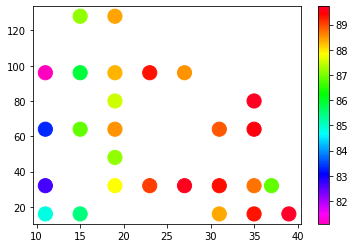

In [19]:

data = {
'K': [   15,   11,   23,   11,   19,   19,   19,   19,   23,   19,   31,   19,   19,   15,   31,   31,   27,   31,   31,   27,   27,   23,   31,   23,   27,   35,   37,   31,   35,   19,   35,   35,   35,   35,   35,   35,   39,   11,   15,   11,   11,   19,   15,   19],
'C': [  128,   96,   96,   64,  128,   32,   32,   96,   96,   96,   64,   64,   96,   96,   32,   32,   32,   32,   32,   32,   96,   96,   32,   32,   96,   32,   32,   16,   64,   80,   16,   64,   64,   80,   16,   64,   16,   64,   16,   16,   32,   48,   64,   80],
'A': [87.19,81.10,89.36,82.48,88.42,87.86,87.86,87.52,89.57,88.69,88.88,88.54,88.73,85.89,89.48,89.51,89.62,89.48,89.51,89.62,88.55,89.03,88.90,89.08,88.53,88.72,86.87,88.40,89.82,88.26,88.81,89.46,89.60,89.68,89.87,89.31,89.72,84.23,85.50,84.86,82.67,87.17,86.89,86.81]
}

df = pd.DataFrame(data)

grouped_multiple = df.groupby(['K', 'C']).agg({'A': ['mean']})
grouped_multiple.columns = ['A_mean']
grouped_multiple = grouped_multiple.reset_index()
#print(grouped_multiple)

#create scatterplot
sc=plt.scatter(grouped_multiple.K, grouped_multiple.C, s=200, c=grouped_multiple.A_mean, cmap='gist_rainbow_r')
plt.colorbar(sc)
plt.show()